In [1]:
import os
os.chdir('/Users/bnowacki/Documents/Git Repositories/rapid-soh-estimation-from-short-pulses')

from rapid_soh_estimation.rapid_soh_estimation.config import *
from rapid_soh_estimation.rapid_soh_estimation.common_methods import *


/opt/anaconda3/envs/envRapidSOH/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


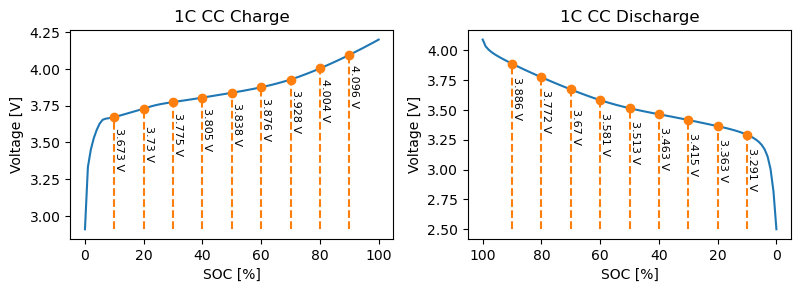

In [105]:
# fig, axes = plt.subplots(figsize=(8,3), ncols=2)
# axes[0].plot(df_interp['chg - SOC (%)'], df_interp['chg - Voltage (V)'])
# axes[1].plot(df_interp['dchg - SOC (%)'], df_interp['dchg - Voltage (V)'])
# for soc in np.arange(10,91,10):
#     chg_v = df_interp.loc[df_interp['chg - SOC (%)'] == soc, 'chg - Voltage (V)'].values[0]
#     axes[0].plot(soc, chg_v, 'o', c='C1')
#     axes[0].plot([soc, soc], [df_interp['chg - Voltage (V)'].min(), chg_v], '--', c='C1')
#     axes[0].annotate(text=f'{round(chg_v, 3)} V', xy=(soc, chg_v-0.35), fontsize=8, rotation=-90)
    
#     dchg_v = df_interp.loc[df_interp['dchg - SOC (%)'] == soc, 'dchg - Voltage (V)'].values[0]
#     axes[1].plot(soc, dchg_v, 'o', c='C1')
#     axes[1].plot([soc, soc], [df_interp['dchg - Voltage (V)'].min(), dchg_v], '--', c='C1')
#     axes[1].annotate(text=f'{round(dchg_v, 3)} V', xy=(soc, dchg_v-0.45), fontsize=8, rotation=-90)

# axes[0].set_title("1C CC Charge")
# axes[0].set_xlabel("SOC [%]")
# axes[0].set_ylabel("Voltage [V]")
# axes[1].set_title("1C CC Discharge")
# axes[1].set_xlabel("SOC [%]")
# axes[1].set_ylabel("Voltage [V]")
# axes[1].set_xlim([105,-5])
# fig.tight_layout(pad=1)
# # temp = Path("/Users/bnowacki/Library/CloudStorage/Dropbox/Ben Nowacki/RPT Protocol Description/Figures").joinpath("NMC Voltage vs SOC.jpeg")
# # fig.savefig(temp, dpi=300)
# plt.show()

In [2]:
cc_data = load_processed_data(data_type='cc')
pulse_data = load_processed_data(data_type='slowpulse')

In [4]:

def create_model(n_hlayers:int, n_neurons:int, act_fnc:str, opt_fnc:str, learning_rate:float, input_shape=(100,)) -> keras.models.Sequential:
	"""Builds a Keras neural network model (MLP) using the specified parameters. The model is optimized for accuracy. Make sure model outputs (if multiple target) are normalized, otherwise optimization will be biased towards one target variable.

	Args:
		n_hlayers (int): Number of fully-connected hidden layers
		n_neurons (int): Number of neurons per hidden layer
		act_fnc (str): Activation function to use (\'tanh\', \'relu\', etc)
		opt_fnc (str): {\'sgd\', \'adam\'} Optimizer function to use 
		learning_rate (float): Learning rate
		input_shape (int, optional): Input shape of model. Defaults to (100,).

	Raises:
		ValueError: _description_

	Returns:
		keras.models.Sequential: compiled Keras model
	"""

	# add input layer to Sequential model
	model = keras.models.Sequential()
	model.add( keras.Input(shape=input_shape) )

	# add hidden layers
	for i in range(n_hlayers):
		model.add( keras.layers.Dense(units=n_neurons, activation=act_fnc) )
		
	# add output layer
	model.add( keras.layers.Dense(7) )

	# compile model with chosen metrics
	opt = None
	if opt_fnc == 'adam':
		opt = keras.optimizers.Adam(learning_rate=learning_rate)
	elif opt_fnc == 'sgd':
		opt = keras.optimizers.SGD(learning_rate=learning_rate)
	else:
		raise ValueError("opt_func must be either \'adam\' or \'sgd\'")

	model.compile(optimizer=opt,
					loss=keras.losses.mean_squared_error,      
					# make sure to normalize all outputs, otherwise DCIR values will drastically skew MSE reading compared to error of predicted SOH
					metrics=['accuracy'] )
	return model


# def get_prediction_error(y_true, y_predicted):
#     '''returns tuple of (MAPE, RMSE)'''
#     mape = []
#     rmse = []
#     # print("y_pred size: ", np.size(y_predicted, axis=1) )
#     # print("y_true size: ", np.size(y_true, axis=1))
#     if len(np.shape(y_true)) > 1:
#         for i in range(0, np.size(y_predicted, axis=1)):
#             mape.append(np.round(mean_absolute_percentage_error(y_true[:,i], y_predicted[:,i]), 4))
#             rmse.append(np.round(root_mean_squared_error(y_true[:,i], y_predicted[:,i]), 4))
#     else:
#         mape.append(np.round(mean_absolute_percentage_error(y_true, y_predicted), 4))
#         rmse.append(np.round(root_mean_squared_error(y_true, y_predicted), 4))
#     mape = np.vstack(mape)
#     rmse = np.vstack(rmse)
#     return mape.reshape(-1), rmse.reshape(-1)


# build model
model = create_model(5, 100, 'tanh', 'sgd', 0.015, input_shape=(100,))

# get modeling data
all_data = deepcopy(pulse_data)
idxs = np.where((all_data['pulse_type'] == 'chg'))# & (all_data['soc'] == 20))
for k in all_data.keys():
	all_data[k] = all_data[k][idxs]
all_data['voltage_rel'] = np.asarray([v - v[0] for v in all_data['voltage']])

modeling_data = create_modeling_data(all_data=all_data, input_feature_keys=['voltage_rel'])

# normalize modeling data inputs and outputs
modeling_data['input_scaler'] = StandardScaler().fit(modeling_data['model_input'])
modeling_data['model_input_scaled'] = modeling_data['input_scaler'].transform(modeling_data['model_input'])
modeling_data['output_scaler'] = StandardScaler().fit(modeling_data['model_output'])
modeling_data['model_output_scaled'] = modeling_data['output_scaler'].transform(modeling_data['model_output'])
    

In [ ]:

# define early stop callback
early_stop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=25, verbose=False, mode='auto', baseline=None, restore_best_weights=True)

# run multiple CVs and average estimation error
num_iters = 5
mape_avgs = []
for i in range(num_iters):
	# generate cross validation splits
	cvSplitter = Custom_CVSplitter(n_splits=3, split_type='group_id', rand_seed=i)
	cv_splits = cvSplitter.split(modeling_data['model_input'], modeling_data['model_output'], modeling_data['cell_id']) 
	cv_splits = list(cv_splits)
	mape_qdchg = []
	for cv_idx, (train_idxs, test_idxs) in enumerate(cv_splits):
		# get train and test data for this cv split
		X_train = modeling_data['model_input_scaled'][train_idxs]
		y_train = modeling_data['model_output_scaled'][train_idxs]
		X_test = modeling_data['model_input_scaled'][test_idxs]
		y_test = modeling_data['model_output_scaled'][test_idxs]

		# train model
		history = model.fit(
			X_train, y_train,
			validation_split = 0.1,
			batch_size = 50,
			epochs = 250,
			callbacks = early_stop, 
			verbose = False)

		y_pred = model.predict(X_test, verbose=False)
		err = mean_absolute_percentage_error(y_test, y_pred)
		mape_qdchg.append(err)

	print(f"Iter {i}: Average MAPE of Q_dchg={round(np.average(np.asarray(mape_qdchg)), 4)}%")
	mape_avgs.append(np.average(np.asarray(mape_qdchg)))
print(f"Average of all runs: MAPE={round(np.average(np.asarray(mape_avgs)), 4)}")



In [ ]:
plt.plot(modeling_data['model_input_scaled'].T, '-')
plt.show()

In [ ]:
import optuna

# OPTUNA model optimization 

def optuna_create_model(trial):
	model = create_model(
		n_hlayers=		trial.suggest_int("n_layers", 1, 5),
		n_neurons=		trial.suggest_int("n_neurons", 8, 128),
		act_fnc=		trial.suggest_categorical("activation", ['relu', 'tanh']),
		opt_fnc=		trial.suggest_categorical("optimizer", ['sgd', 'adam']),
		learning_rate=	trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
		input_shape=	(100,)
	)
	return model

def optuna_objective(trial):
	cvSplitter = Custom_CVSplitter(n_splits=3, split_type='group_id', rand_seed=0)
	cv_splits = cvSplitter.split(modeling_data['model_input'], modeling_data['model_output'], modeling_data['cell_id']) 
	cv_splits = list(cv_splits)
	train_idxs, test_idxs = cv_splits[0]
	X_train = modeling_data['model_input_scaled'][train_idxs]
	y_train = modeling_data['model_output_scaled'][train_idxs]
	X_test = modeling_data['model_input_scaled'][test_idxs]
	y_test = modeling_data['model_output_scaled'][test_idxs]
	
	model = optuna_create_model(trial)
	model.fit(
		X_train, y_train,
		validation_split = 0.1,
		batch_size = 50,
		epochs = 100,
		# callbacks = early_stop, 
		verbose = False)
	
	y_pred = model.predict(X_test, verbose=False)
	
	err = mean_squared_error(y_test, y_pred)
	return err

N_TRIALS = 100
study = optuna.create_study(direction="minimize", study_name="pulse_model_optimization")
study.optimize(optuna_objective, n_trials=N_TRIALS, n_jobs=-1)
print('*'*100)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("Best Params:")
print(study.best_params)
print('*'*100)

# get the optimized model
opt_model = optuna_create_model(study.best_trial)
opt_model.summary()